In [1]:
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
# setting up notebook variables
date_chosen = '2025-05-17'

Let's begin by setting up some quick stats on ERCOT and visuals!

In [3]:
# loading in ercot lmp data
# next step will be to set up function to concat all datafiles and output as df here
ercot_data=pl.read_csv(f'datasets/ercot_lmp_data/lmp_node_zone_hub_csv/{date_chosen}_lmp_node_zone_hub.csv')

In [4]:
def transform_ercot_data(ercot_df: object):
    '''
    given ercot df or file, return a transformed verion
    changes scedtimestamp to datetime type...
    '''

    ercot_df = ercot_df.rename(
        {"LMP": "5min_lmp",
         "settlementPoint": "node_id",
         "SCEDTimestamp": "timestamp"
         })
    
    # removing the seconds of ERCOT time stamp, causing issues....
    ercot_df = ercot_df.with_columns(
        pl.col("timestamp").str.replace(r'..$', "00")
    )
    
    ercot_df = ercot_df.with_columns(
        pl.col("timestamp").str.strptime(pl.Datetime, format="%Y-%m-%dT%H:%M:%S")
    )
    
    ercot_df = ercot_df.with_columns(
        pl.lit("ERCOT").alias("iso_id"),
        pl.col('timestamp').dt.hour().alias('hour')
    )

    return ercot_df

In [5]:
# quick info on data set
ercot_data=transform_ercot_data(ercot_df=ercot_data)
ercot_data.describe()

statistic,timestamp,repeatHourFlag,node_id,5min_lmp,iso_id,hour
str,str,f64,str,f64,str,f64
"""count""","""500000""",500000.0,"""500000""",500000.0,"""500000""",500000.0
"""null_count""","""0""",0.0,"""0""",0.0,"""0""",0.0
"""mean""","""2025-05-18 00:14:58.818480""",0.0,null,30.051929,null,11.616782
"""std""",null,null,null,23.372946,null,6.017352
"""min""","""2025-05-17 04:30:00""",0.0,"""7RNCHSLR_ALL""",-540.49,"""ERCOT""",0.0
"""25%""","""2025-05-17 14:15:00""",null,null,21.74,null,7.0
"""50%""","""2025-05-18 00:15:00""",null,null,25.53,null,12.0
"""75%""","""2025-05-18 10:20:00""",null,null,33.44,null,16.0
"""max""","""2025-05-18 20:10:00""",0.0,"""ZIER_SLR_ALL""",1186.32,"""ERCOT""",23.0


In [6]:
# creating a list of the main load zones/trading hubs for LMPs
# these are the main hubs and will be used so that we can track correlation
ercot_hubs = [
    "HB_BUSAVG",
    "HB_HOUSTON", 	
    "HB_HUBAVG",	
    "HB_NORTH",	
    "HB_PAN",
    "HB_SOUTH", 	
    "HB_WEST", 	
    "LZ_AEN", 	
    "LZ_CPS", 	
    "LZ_HOUSTON",	
    "LZ_LCRA", 	
    "LZ_NORTH", 	
    "LZ_RAYBN",	
    "LZ_SOUTH", 	
    "LZ_WEST",
]

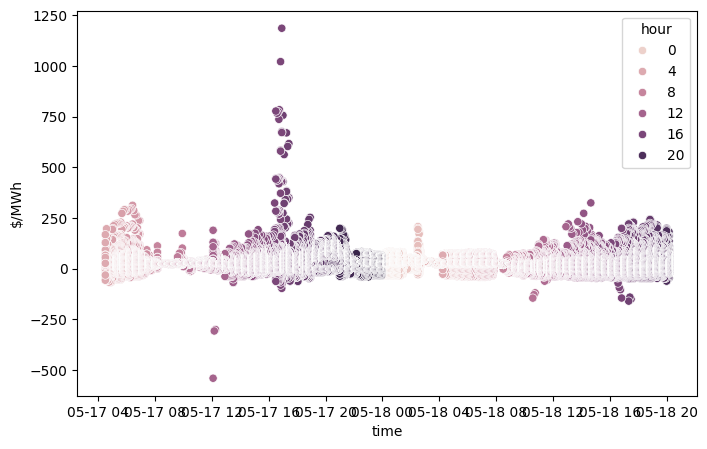

In [7]:
# now let's plot data
plt.figure(figsize=[8,5])

sns.scatterplot(data=ercot_data, x='timestamp', y='5min_lmp', hue='hour')

plt.xlabel('time')
plt.ylabel('$/MWh')

plt.show()

<Figure size 640x480 with 0 Axes>

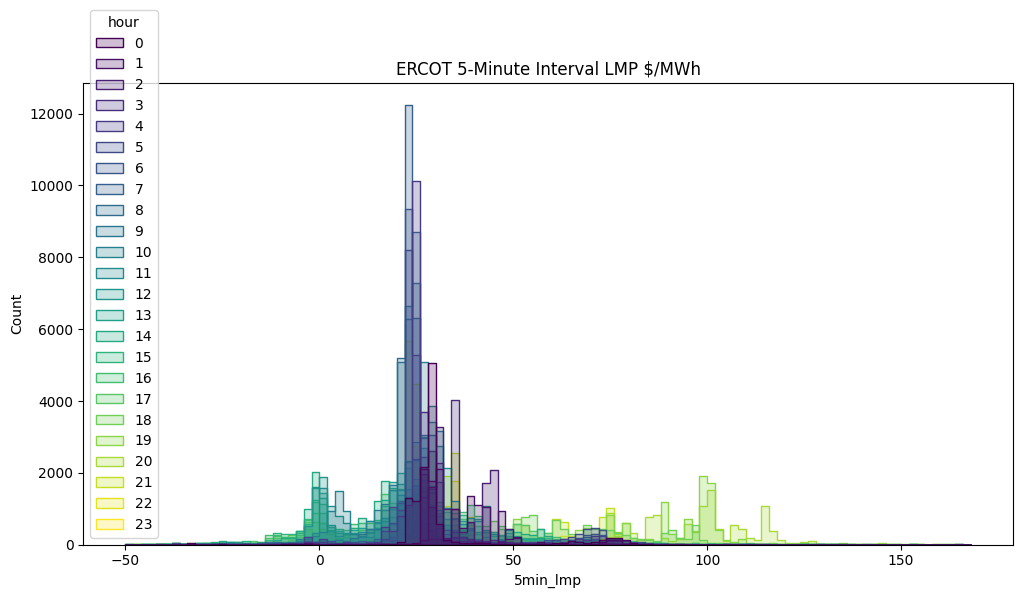

<Figure size 640x480 with 0 Axes>

In [8]:
# lets plot distribution of pricing
plt.figure(figsize=[12,6])

bins=range(-50, 170, 2) # low, high and seperate by N values

histplot= sns.histplot(data=ercot_data, x='5min_lmp', bins=bins, kde=False, hue='hour', 
             palette='viridis', element='step')


plt.title("ERCOT 5-Minute Interval LMP $/MWh")
plt.grid(False)
plt.figure()

In [9]:
# let's filter for only trading hub/zone data on LMPs
ercot_main_hubs = ercot_data.filter(
    pl.col('node_id').is_in(ercot_hubs)
)

ercot_main_hubs.describe()

statistic,timestamp,repeatHourFlag,node_id,5min_lmp,iso_id,hour
str,str,f64,str,f64,str,f64
"""count""","""7477""",7477.0,"""7477""",7477.0,"""7477""",7477.0
"""null_count""","""0""",0.0,"""0""",0.0,"""0""",0.0
"""mean""","""2025-05-18 00:15:04.212919""",0.0,null,30.656469,null,11.61736
"""std""",null,null,null,19.359407,null,6.017611
"""min""","""2025-05-17 04:30:00""",0.0,"""HB_BUSAVG""",-16.58,"""ERCOT""",0.0
"""25%""","""2025-05-17 14:15:00""",null,null,22.57,null,7.0
"""50%""","""2025-05-18 00:15:00""",null,null,26.1,null,12.0
"""75%""","""2025-05-18 10:20:00""",null,null,33.19,null,16.0
"""max""","""2025-05-18 20:10:00""",0.0,"""LZ_WEST""",122.79,"""ERCOT""",23.0


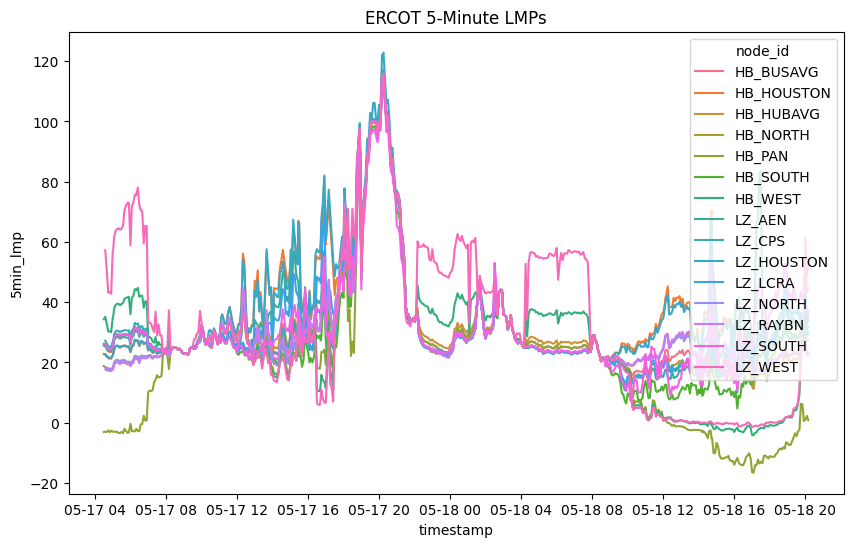

In [10]:
plt.figure(figsize=[10,6])

sns.lineplot(data=ercot_main_hubs, x='timestamp', y='5min_lmp', hue='node_id')

plt.title('ERCOT 5-Minute LMPs')

plt.show()

We now want to create heat maps to visualize correlations. We want to identify the following: 
1. identify nodes with consistent lower or higher LMP pricing
2. daily price patterns across all nodes
3. outlier hours or nodes with unusual pricing

In [17]:
# creating a function where, given a dataframe with data, return necessary framework
# to process dfs
def lmp_node_hour_hmap(dataframe: object, plot_title: None):
    '''
    Args
        provide a dataframe in polars format and it will make transformations

    Output
        provides user with necessary objects needed to visualize correlations

    Needed: nodenames as node_id, hour values as hour and 5min lmps as 5min_lmp
    provide a title for the plot
    '''
    # group by node_id and hour then calculate mean of lmp values
    pandas_df = dataframe.to_pandas()

    pivot_df = pd.pivot_table(
        pandas_df, values='5min_lmp', index='node_id', columns='hour', aggfunc='mean'
    )

    plt.figure(figsize=[12,4])

    ax = sns.heatmap(pivot_df, cmap='coolwarm', fmt='.0f',
                    annot=True, linewidths=0.5)
    
    plt.title(f'{plot_title}')

    plt.show()

    return pivot_df


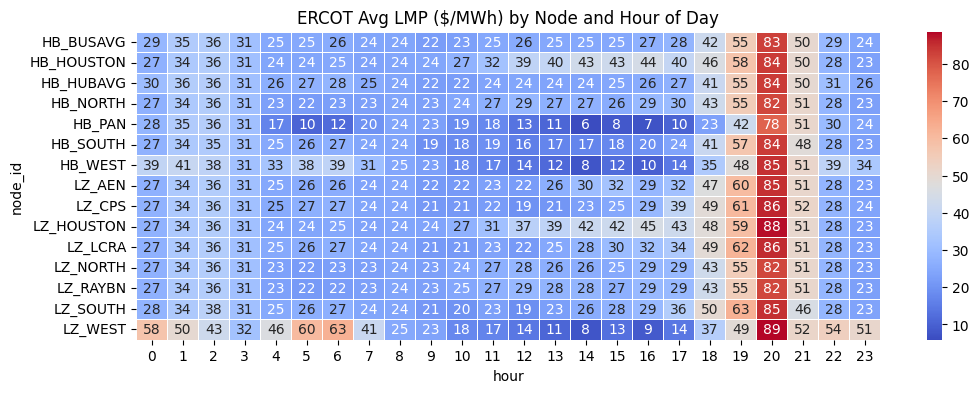

In [18]:
ercot_hmap_df = lmp_node_hour_hmap(dataframe=ercot_main_hubs, 
                         plot_title='ERCOT Avg LMP ($/MWh) by Node and Hour of Day')

In [19]:
def lmp_corr_matrix(dataframe: object, index=None, columns=None):
    '''
    Returns a correlation matrix
    '''
    pandas_df = dataframe.to_pandas()

    # create pivot table with timestamps as rows and nodes as columns

    if index == None or columns == None:
        node_pivot = pd.pivot_table(
            data=pandas_df, values='5min_lmp', index='hour', columns='node_id', 
            aggfunc='mean'
        )

    else: 
        node_pivot = pd.pivot_table(
            data=pandas_df, values='5min_lmp', index=f'{index}', columns=f'{columns}', 
            aggfunc='mean'
        )
        
    # correlation matrix
    corr_matrix = node_pivot.corr()

    plt.figure(figsize=[20, 4])

    sns.heatmap(data=corr_matrix, annot=False, cmap='rocket', square=True, 
                linewidth=0.5, vmin=0.75, vmax=1)
    
    plt.title('ERCOT Hub Correlation Matrix')
    
    plt.show()

    return corr_matrix

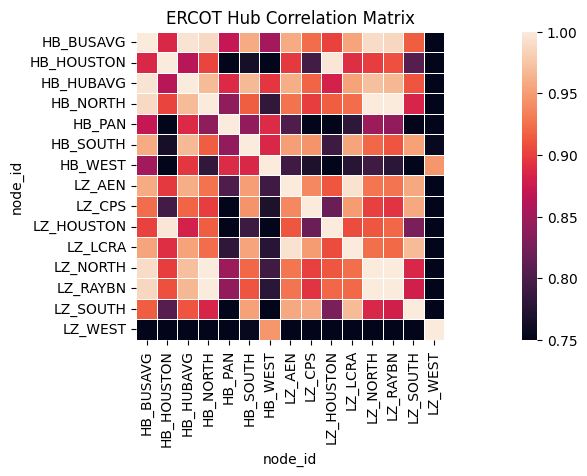

In [20]:
ercot_corr_matrix = lmp_corr_matrix(dataframe=ercot_main_hubs, 
                                    index='timestamp', columns='node_id')

We will now set up data to visualize a lagplot, which answers the following Qs:
1. distribution of model: linear (=autoregressive model), 
2. outliers: finding extreme values
3. randomness: whether dataset is random or not
4. seasonality: checking if data has seasonality
5. autocorrelation: whethere it is present in plot

In [ ]:
def create_lag_plot(dataframe: object, lag_by:int, selected_node:str):
    '''
    Given a dataframe and input params, generate a lag plot
    '''
    sorted_df = dataframe.sort(['node_id', 'timestamp'])
    df_with_lag = sorted_df.with_columns(
        pl.col('5min_lmp').shift(lag_by).over('node_id').alias(f'5min_lmp_lag{lag_by}')
    )
    df_lag_clean = df_with_lag.drop_nulls(subset=[f'5min_lmp_lag{lag_by}'])
    df_node = df_lag_clean.filter(
        pl.col('node_id') == selected_node
    )
    df_pandas = df_node.select(['5min_lmp', f'5min_lmp_lag{lag_by}']).to_pandas()

    plt.figure(figsize=[8,6])
    sns.scatterplot(data=df_pandas, x='5min_lmp', y=f'5min_lmp_lag{lag_by}', alpha=0.5)

    plt.title(f'Lag Plot for {selected_node}')
    plt.grid(True)
    plt.show()

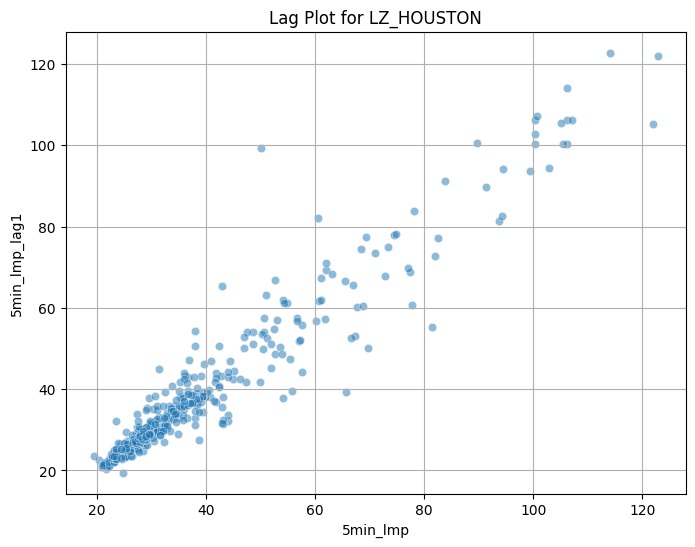

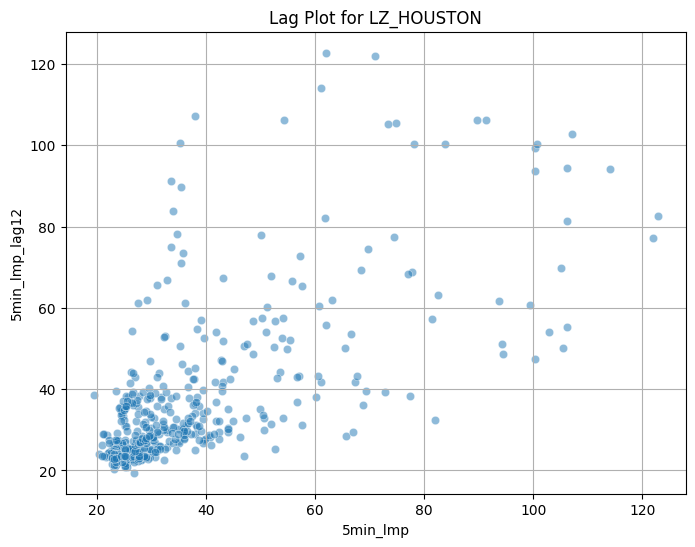

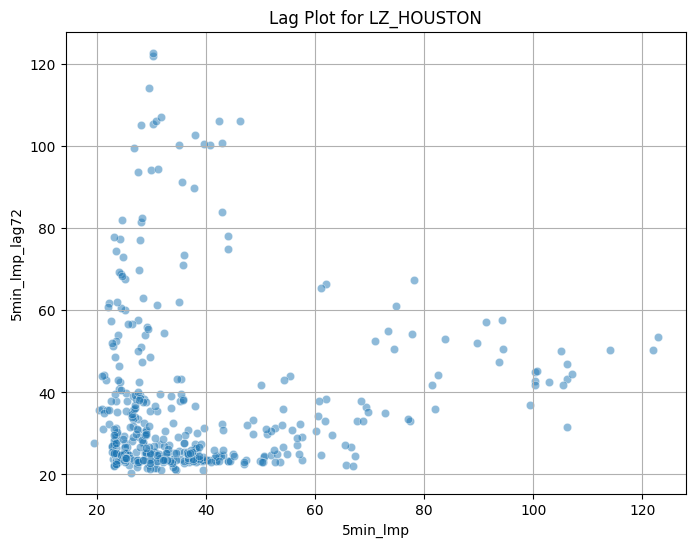

In [22]:
create_lag_plot(dataframe=ercot_data, lag_by=1, selected_node="LZ_HOUSTON")
create_lag_plot(dataframe=ercot_data, lag_by=12, selected_node="LZ_HOUSTON")
create_lag_plot(dataframe=ercot_data, lag_by=72, selected_node="LZ_HOUSTON")